Exemple de notebook : Analyse de sentiments avec DistilBERT
🔧 Objectifs :

    Charger un dataset NLP

    Utiliser un modèle Transformer (DistilBERT) pour la classification de texte

    Évaluer les performances

    Visualiser les résultats


📦 Étape 0 : Installation des bibliothèques


In [1]:
!pip install transformers datasets evaluate -q

📥 Étape 1 : Chargement du dataset IMDB

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset["train"][0]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

🧹 Étape 2 : Prétraitement du texte (tokenisation)


In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/home/nicolascassonnet/Documents/WORK/aura-clinical-nlp/AURA-fastapi/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

🧠 Étape 3 : Chargement du modèle DistilBERT

In [4]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️‍♀️ Étape 4 : Entraînement avec Trainer

In [6]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return accuracy.compute(predictions=preds, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(2000)),  # pour aller vite
    eval_dataset=tokenized_datasets["test"].select(range(500)),
    compute_metrics=compute_metrics,
)

trainer.train()


/home/nicolascassonnet/Documents/WORK/aura-clinical-nlp/AURA-fastapi/.venv/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.5932486653327942, 'eval_accuracy': 0.774, 'eval_runtime': 22.4581, 'eval_samples_per_second': 22.264, 'eval_steps_per_second': 2.805, 'epoch': 1.0}
{'loss': 0.3041, 'grad_norm': 31.679264068603516, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.31383514404296875, 'eval_accuracy': 0.914, 'eval_runtime': 22.4667, 'eval_samples_per_second': 22.255, 'eval_steps_per_second': 2.804, 'epoch': 2.0}
{'train_runtime': 528.1452, 'train_samples_per_second': 7.574, 'train_steps_per_second': 0.947, 'train_loss': 0.3040797424316406, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.3040797424316406, metrics={'train_runtime': 528.1452, 'train_samples_per_second': 7.574, 'train_steps_per_second': 0.947, 'total_flos': 529869594624000.0, 'train_loss': 0.3040797424316406, 'epoch': 2.0})

📊 Étape 5 : Évaluation du modèle


In [7]:
trainer.evaluate()

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.31383514404296875,
 'eval_accuracy': 0.914,
 'eval_runtime': 22.4672,
 'eval_samples_per_second': 22.255,
 'eval_steps_per_second': 2.804,
 'epoch': 2.0}

🔎 Étape 6 : Prédiction sur de nouveaux textes


In [8]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentiment_analysis([
    "This movie was a masterpiece, I loved it!",
    "I hated every second of it. Terrible experience."
])


[{'label': 'LABEL_1', 'score': 0.995037853717804},
 {'label': 'LABEL_0', 'score': 0.9884337782859802}]

📉 Étape 7 : Visualisation (matrice de confusion)

  0%|          | 0/63 [00:00<?, ?it/s]

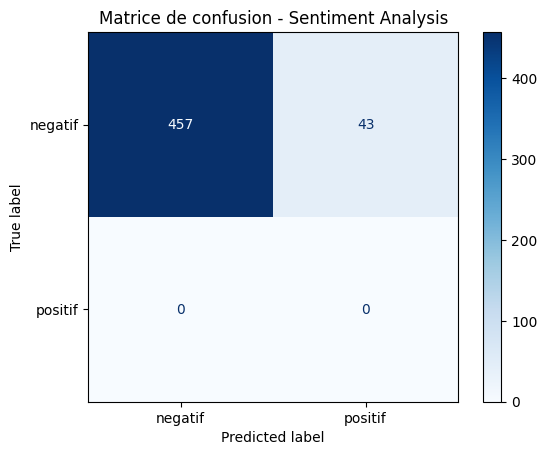

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
predictions = trainer.predict(tokenized_datasets["test"].select(range(500)))
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negatif", "positif"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Sentiment Analysis")
plt.show()


✅ Résultats attendus :

    Accuracy autour de 85–90 % même sans fine-tuning long.

    Prédictions cohérentes.

    Notebook lisible, reproductible et exploitable pour présentation de projet.